In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitor_sma1', 'station_visitors_mean', 'all_count_y1', 'all_count_y5'])
len(lag_cols)

14

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [17]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [18]:
import cPickle as pickle
indexes=[pickle.load(open(u)) for  u in ['train_idx_1.pkl','train_idx_2.pkl','train_idx_3.pkl']]

In [19]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [27]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.py'>

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    return  df2['error2'].mean()
def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478-39)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [31]:
reload(rrvf)
import rrvf_data
def _run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=True,use_dropout=False,
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [32]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [33]:
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('lstm_valid{}_preds_tmp.pkl'.format(j),'wb'))



1
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 290583 records out of 322481 records
valid has 31898 records out of 322481 records
train has 5803 records out of 5803 records
no valid set
2270
0
14 1 (1, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2270/2270 [==============================] - 42s 18ms/step - loss: 0.4119 - total_loss: 0.4119 - reg_loss: 0.4119 - val_loss: 0.3420 - val_total_loss: 0.3420 - val_reg_loss: 0.3420
Epoch 2/100
2270/2270 [==============================] - 41s 18ms/step - loss: 0.3209 - total_loss: 0.3209 - reg_loss: 0.3209 - val_loss: 0.3065 - val_total_loss: 0.3065 - val_reg_loss: 0.3065
Epoch 3/100
2270/2270 [==============================] - 41s 18ms/step - loss: 0.3126 - total_loss: 0.3126 - reg_loss: 0.3126 - val_loss: 0.2920 - val_total_loss: 0.2920 - val_reg_loss: 0.2920
E

Epoch 23/100
2270/2270 [==============================] - 41s 18ms/step - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551 - val_loss: 0.2592 - val_total_loss: 0.2592 - val_reg_loss: 0.2592
Epoch 24/100
2270/2270 [==============================] - 41s 18ms/step - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527 - val_loss: 0.2568 - val_total_loss: 0.2568 - val_reg_loss: 0.2568
best_epochs [19, 21, 16, 24, 12]
individual loss [ 0.25637859  0.25827124  0.25934997  0.2593576   0.26038557]
[ 0.18421375  0.15130959  0.14528647  0.2463125   0.2728777 ] 0.251380063174
best_epochs [19, 21, 16, 24, 12]
0.251380063177 0.251380063177
(1, 0.25138006317686962)
0.251380063177
best_epochs [19, 21, 16, 24, 12]
(5803, 1) 2.7866937761 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889110  0.040000  0.262872    7  2017-04-16
472     2.507290  2.614714 -0.107424  0.256888    1  2017-04-17
473     2.661330  2.684867 -0.023538  0.282834    2  2017-04-18
474     2.754815  2.883484 -0.128669  0.269762    3  2017-04-19
475     2.713762  2.813402 -0.099640  0.288406    4  2017-04-20
476     2.999000  2.989478  0.009522  0.177534    5  2017-04-21
477     3.075529  3.167652 -0.092123  0.217774    6  2017-04-22

best_epochs [19, 21, 16, 24, 12]
(829, 1) 2.75593715646 

2
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 289836 records out of 321652 records
valid has 31816 records out of 321652 records
train has 6632 records out of 6632 records
no valid set
2264
0
14 1 (2, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2263/2264 [============================>.] - ETA: 0s - loss: 3.8285 - total_loss: 3.8285 - reg_loss: 3.8285Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2264/2264 [==============================] - 41s 18ms/step - loss: 3.8272 - total_loss: 3.8272 - reg_loss: 3.8272 - val_loss: 1.0506 - val_total_loss: 1.0506 - val_reg_loss: 1.0506
best_epochs [1]
individual loss [ 1.05077603]
[ 1.] 1.05077602733
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 

0.253757019241 0.253757019241
(1, 0.25375701924079613)
0.253757019241
best_epochs [11, 15, 12, 14, 13]
(6632, 1) 2.73727427998 (6632, 2)


y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.888386  0.040724  0.260740    6  2017-04-15
471     2.507290  2.540319 -0.033028  0.256489    7  2017-04-16
472     2.661330  2.676952 -0.015622  0.284101    1  2017-04-17
473     2.754815  2.801000 -0.046185  0.241457    2  2017-04-18
474     2.713762  2.836795 -0.123034  0.301550    3  2017-04-19
475     2.999000  2.980605  0.018395  0.175087    4  2017-04-20
476     3.075529  3.099439 -0.023910  0.215955    5  2017-04-21

best_epochs [11, 15, 12, 14, 13]
(829, 1) 2.64917266303 

3
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 289089 records out of 320823 records
valid has 31734 records out of 320823 records
train has 7461 records out of 7461 records
no valid set
2258
0
14 1 (3, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2257/2258 [============================>.] - ETA: 0s - loss: 3.8349 - total_loss: 3.8349 - reg_loss: 3.8349Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2258/2258 [==============================] - 42s 18ms/step - loss: 3.8336 - total_loss: 3.8336 - reg_loss: 3.8336 - val_loss: 1.0563 - val_total_loss: 1.0563 - val_reg_loss: 1.0563
best_epochs [1]
individual loss [ 1.05652896]
[ 1.] 1.05652896099
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 

2258/2258 [==============================] - 41s 18ms/step - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654 - val_loss: 0.2564 - val_total_loss: 0.2564 - val_reg_loss: 0.2564
Epoch 21/100
2258/2258 [==============================] - 41s 18ms/step - loss: 0.2638 - total_loss: 0.2638 - reg_loss: 0.2638 - val_loss: 0.2624 - val_total_loss: 0.2624 - val_reg_loss: 0.2624
Epoch 22/100
2258/2258 [==============================] - 41s 18ms/step - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628 - val_loss: 0.2592 - val_total_loss: 0.2592 - val_reg_loss: 0.2592
Epoch 23/100
2258/2258 [==============================] - 41s 18ms/step - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589 - val_loss: 0.2614 - val_total_loss: 0.2614 - val_reg_loss: 0.2614
Epoch 24/100
2258/2258 [==============================] - 41s 18ms/step - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569 - val_loss: 0.2642 - val_total_loss: 0.2642 - val_reg_loss: 0.2642
Epoch 25/100
2258/2258 [===================

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.942272 -0.013162  0.264815    5  2017-04-14
470     2.507290  2.620011 -0.112720  0.269287    6  2017-04-15
471     2.661330  2.710752 -0.049422  0.287325    7  2017-04-16
472     2.754815  2.879374 -0.124559  0.265853    1  2017-04-17
473     2.713762  2.834872 -0.121110  0.295675    2  2017-04-18
474     2.999000  2.993894  0.005106  0.184308    3  2017-04-19
475     3.075529  3.120520 -0.044991  0.218654    4  2017-04-20

best_epochs [20, 16, 12, 22, 15]
(829, 1) 2.8532384242 

4
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 288342 records out of 319994 records
valid has 31652 records out of 319994 records
train has 8290 records out of 8290 records
no valid set
2252
0
14 1 (4, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2249/2252 [============================>.] - ETA: 0s - loss: 3.8452 - total_loss: 3.8452 - reg_loss: 3.8452Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2252/2252 [==============================] - 41s 18ms/step - loss: 3.8415 - total_loss: 3.8415 - reg_loss: 3.8415 - val_loss: 1.0627 - val_total_loss: 1.0627 - val_reg_loss: 1.0627
best_epochs [1]
individual loss [ 1.06243793]
[ 1.] 1.06243792996
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 1

2252/2252 [==============================] - 41s 18ms/step - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654 - val_loss: 0.2631 - val_total_loss: 0.2631 - val_reg_loss: 0.2631
Epoch 21/100
2252/2252 [==============================] - 41s 18ms/step - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636 - val_loss: 0.2575 - val_total_loss: 0.2575 - val_reg_loss: 0.2575
Epoch 22/100
2252/2252 [==============================] - 41s 18ms/step - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606 - val_loss: 0.2642 - val_total_loss: 0.2642 - val_reg_loss: 0.2642
best_epochs [17, 15, 21, 19, 12]
individual loss [ 0.25795822  0.26055964  0.25939414  0.2601412   0.26246963]
[ 0.21018502  0.20773092  0.28479752  0.13232759  0.16495895] 0.253923039866
best_epochs [17, 15, 21, 19, 12]
0.253923039859 0.253923039859
(1, 0.25392303985925896)
0.253923039859
best_epochs [17, 15, 21, 19, 12]
(8290, 1) 2.73944649532 (8290, 2)


y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.935132 -0.006022  0.265005    4  2017-04-13
469     2.507290  2.609504 -0.102213  0.266118    5  2017-04-14
470     2.661330  2.641917  0.019412  0.279097    6  2017-04-15
471     2.754815  2.818029 -0.063214  0.250706    7  2017-04-16
472     2.713762  2.861226 -0.147464  0.336119    1  2017-04-17
473     2.999000  3.013008 -0.014008  0.185455    2  2017-04-18
474     3.075529  3.088704 -0.013174  0.218206    3  2017-04-19

best_epochs [17, 15, 21, 19, 12]
(829, 1) 3.052143733 

5
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 287595 records out of 319165 records
valid has 31570 records out of 319165 records
train has 9119 records out of 9119 records
no valid set
2246
0
14 1 (5, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2246/2246 [==============================] - 41s 18ms/step - loss: 0.5949 - total_loss: 0.5949 - reg_loss: 0.5949 - val_loss: 0.2929 - val_total_loss: 0.2929 - val_reg_loss: 0.2929
Epoch 2/100
2246/2246 [==============================] - 40s 18ms/step - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171 - val_loss: 0.2887 - val_total_loss: 0.2887 - val_reg_loss: 0.2887
Epoch 3/100
2246/2246 [==============================] - 40s 18ms/step - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094 - val_loss: 0.

(9119, 1) 2.76085543453 (9119, 2)


y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.926066  0.003044  0.266063    3  2017-04-12
468     2.507290  2.670165 -0.162875  0.291633    4  2017-04-13
469     2.661330  2.681942 -0.020612  0.290123    5  2017-04-14
470     2.754815  2.787365 -0.032550  0.246866    6  2017-04-15
471     2.713762  2.823152 -0.109390  0.301114    7  2017-04-16
472     2.999000  3.081809 -0.082809  0.201727    1  2017-04-17
473     3.075529  3.121869 -0.046340  0.223704    2  2017-04-18

best_epochs [16, 15, 14, 17, 13]
(829, 1) 2.68870048568 

6
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 286848 records out of 318336 records
valid has 31488 records out of 318336 records
train has 9948 records out of 9948 records
no valid set
2241
0
14 1 (6, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2239/2241 [============================>.] - ETA: 0s - loss: 3.8636 - total_loss: 3.8636 - reg_loss: 3.8636Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2241/2241 [==============================] - 41s 18ms/step - loss: 3.8610 - total_loss: 3.8610 - reg_loss: 3.8610 - val_loss: 1.0764 - val_total_loss: 1.0764 - val_reg_loss: 1.0764
best_epochs [1]
individual loss [ 1.07483351]
[ 1.] 1.07483351378
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.925158  0.003952  0.267094    2  2017-04-11
467     2.507290  2.602437 -0.095146  0.281940    3  2017-04-12
468     2.661330  2.609771  0.051559  0.293554    4  2017-04-13
469     2.754815  2.721611  0.033204  0.249889    5  2017-04-14
470     2.713762  2.776068 -0.062306  0.271001    6  2017-04-15
471     2.999000  3.024454 -0.025454  0.180714    7  2017-04-16
472     3.075529  3.116054 -0.040525  0.214670    1  2017-04-17

best_epochs [10, 12, 11, 14, 8]
(829, 1) 2.52094913692 

7
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 286101 records out of 317507 records
valid has 31406 records out of 317507 records
train has 10777 records out of 10777 records
no valid set
2235
0
14 1 (7, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2234/2235 [============================>.] - ETA: 0s - loss: 3.8677 - total_loss: 3.8677 - reg_loss: 3.8677Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2235/2235 [==============================] - 41s 18ms/step - loss: 3.8664 - total_loss: 3.8664 - reg_loss: 3.8664 - val_loss: 1.0830 - val_total_loss: 1.0830 - val_reg_loss: 1.0830
best_epochs [1]
individual loss [ 1.08262339]
[ 1.] 1.0826233855
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 

2235/2235 [==============================] - 40s 18ms/step - loss: 0.2736 - total_loss: 0.2736 - reg_loss: 0.2736 - val_loss: 0.2740 - val_total_loss: 0.2740 - val_reg_loss: 0.2740
Epoch 21/100
2235/2235 [==============================] - 41s 18ms/step - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707 - val_loss: 0.2726 - val_total_loss: 0.2726 - val_reg_loss: 0.2726
Epoch 22/100
2235/2235 [==============================] - 41s 18ms/step - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683 - val_loss: 0.2735 - val_total_loss: 0.2735 - val_reg_loss: 0.2735
Epoch 23/100
2235/2235 [==============================] - 41s 18ms/step - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674 - val_loss: 0.2732 - val_total_loss: 0.2732 - val_reg_loss: 0.2732
Epoch 24/100
2235/2235 [==============================] - 41s 18ms/step - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631 - val_loss: 0.2768 - val_total_loss: 0.2768 - val_reg_loss: 0.2768
best_epochs [19, 15, 11, 18, 13]
individual

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.903272  0.025838  0.271056    1  2017-04-10
466     2.507290  2.653036 -0.145745  0.288984    2  2017-04-11
467     2.661330  2.626807  0.034522  0.296360    3  2017-04-12
468     2.754815  2.778819 -0.024005  0.255767    4  2017-04-13
469     2.713762  2.779694 -0.065932  0.275476    5  2017-04-14
470     2.999000  2.981448  0.017552  0.173781    6  2017-04-15
471     3.075529  3.088838 -0.013309  0.212705    7  2017-04-16

best_epochs [19, 15, 11, 18, 13]
(829, 1) 2.57269276385 

8
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 285354 records out of 316678 records
valid has 31324 records out of 316678 records
train has 11606 records out of 11606 records
no valid set
2229
0
14 1 (8, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2227/2229 [============================>.] - ETA: 0s - loss: 3.8758 - total_loss: 3.8758 - reg_loss: 3.8758Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2229/2229 [==============================] - 41s 18ms/step - loss: 3.8733 - total_loss: 3.8733 - reg_loss: 3.8733 - val_loss: 1.0870 - val_total_loss: 1.0870 - val_reg_loss: 1.0870
best_epochs [1]
individual loss [ 1.08792025]
[ 1.] 1.08792025004
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2229/2229 [==============================] - 40s 18ms/step - loss: 0.2847 - total_loss: 0.2847 - reg_loss: 0.2847 - val_loss: 0.2729 - val_total_loss: 0.2729 - val_reg_loss: 0.2729
Epoch 16/100
2229/2229 [==============================] - 41s 18ms/step - loss: 0.2833 - total_loss: 0.2833 - reg_loss: 0.2833 - val_loss: 0.2759 - val_total_loss: 0.2759 - val_reg_loss: 0.2759
Epoch 17/100
2229/2229 [==============================] - 40s 18ms/step - loss: 0.2804 - total_loss: 0.2804 - reg_loss: 0.2804 - val_loss: 0.2781 - val_total_loss: 0.2781 - val_reg_loss: 0.2781
Epoch 18/100
2229/2229 [==============================] - 40s 18ms/step - loss: 0.2787 - total_loss: 0.2787 - reg_loss: 0.2787 - val_loss: 0.2767 - val_total_loss: 0.2767 - val_reg_loss: 0.2767
Epoch 19/100
2229/2229 [==============================] - 41s 18ms/step - loss: 0.2764 - total_loss: 0.2764 - reg_loss: 0.2764 - val_loss: 0.2791 - val_total_loss: 0.2791 - val_reg_loss: 0.2791
Epoch 20/100
2229/2229 [===================

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.929297 -0.000187  0.275519    7  2017-04-09
465     2.507290  2.643362 -0.136071  0.289335    1  2017-04-10
466     2.661330  2.680655 -0.019325  0.302327    2  2017-04-11
467     2.754815  2.766705 -0.011890  0.254479    3  2017-04-12
468     2.713762  2.784827 -0.071066  0.286306    4  2017-04-13
469     2.999000  2.959347  0.039653  0.182529    5  2017-04-14
470     3.075529  3.130238 -0.054709  0.212055    6  2017-04-15

best_epochs [15, 13, 16, 18, 20]
(829, 1) 2.61638114175 

9
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 284607 records out of 315849 records
valid has 31242 records out of 315849 records
train has 12435 records out of 12435 records
no valid set
2223
0
14 1 (9, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2221/2223 [============================>.] - ETA: 0s - loss: 3.8831 - total_loss: 3.8831 - reg_loss: 3.8831Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2223/2223 [==============================] - 41s 18ms/step - loss: 3.8804 - total_loss: 3.8804 - reg_loss: 3.8804 - val_loss: 1.0950 - val_total_loss: 1.0950 - val_reg_loss: 1.0950
best_epochs [1]
individual loss [ 1.09554176]
[ 1.] 1.09554176111
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

Epoch 13/100
2223/2223 [==============================] - 41s 18ms/step - loss: 0.2890 - total_loss: 0.2890 - reg_loss: 0.2890 - val_loss: 0.2774 - val_total_loss: 0.2774 - val_reg_loss: 0.2774
best_epochs [8, 13, 11, 12, 10]
individual loss [ 0.27745803  0.276564    0.27918931  0.27833487  0.28173397]
[ 0.25287182  0.23920078  0.12594669  0.24857614  0.13340457] 0.271883807189
best_epochs [8, 13, 11, 12, 10]
0.271883807199 0.271883807199
(1, 0.27188380719949395)
0.271883807199
best_epochs [8, 13, 11, 12, 10]
(12435, 1) 2.76254962212 (12435, 2)


y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.875360  0.053750  0.268825    6  2017-04-08
464     2.507290  2.645502 -0.138211  0.282947    7  2017-04-09
465     2.661330  2.710042 -0.048712  0.301567    1  2017-04-10
466     2.754815  2.785401 -0.030586  0.251155    2  2017-04-11
467     2.713762  2.788832 -0.075070  0.272330    3  2017-04-12
468     2.999000  2.965234  0.033766  0.183764    4  2017-04-13
469     3.075529  3.075401  0.000128  0.209999    5  2017-04-14

best_epochs [8, 13, 11, 12, 10]
(829, 1) 2.68263060912 

10
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 283860 records out of 315020 records
valid has 31160 records out of 315020 records
train has 13264 records out of 13264 records
no valid set
2217
0
14 1 (10, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2214/2217 [============================>.] - ETA: 0s - loss: 3.8835 - total_loss: 3.8835 - reg_loss: 3.8835Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2217/2217 [==============================] - 41s 18ms/step - loss: 3.8796 - total_loss: 3.8796 - reg_loss: 3.8796 - val_loss: 1.1003 - val_total_loss: 1.1003 - val_reg_loss: 1.1003
best_epochs [1]
individual loss [ 1.10121077]
[ 1.] 1.10121076817
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

Epoch 8/100
2217/2217 [==============================] - 40s 18ms/step - loss: 0.3024 - total_loss: 0.3024 - reg_loss: 0.3024 - val_loss: 0.2827 - val_total_loss: 0.2827 - val_reg_loss: 0.2827
Epoch 9/100
2217/2217 [==============================] - 40s 18ms/step - loss: 0.3004 - total_loss: 0.3004 - reg_loss: 0.3004 - val_loss: 0.2993 - val_total_loss: 0.2993 - val_reg_loss: 0.2993
Epoch 10/100
2217/2217 [==============================] - 41s 18ms/step - loss: 0.2986 - total_loss: 0.2986 - reg_loss: 0.2986 - val_loss: 0.2818 - val_total_loss: 0.2818 - val_reg_loss: 0.2818
Epoch 11/100
2217/2217 [==============================] - 40s 18ms/step - loss: 0.2973 - total_loss: 0.2973 - reg_loss: 0.2973 - val_loss: 0.2843 - val_total_loss: 0.2843 - val_reg_loss: 0.2843
Epoch 12/100
2217/2217 [==============================] - 41s 18ms/step - loss: 0.2940 - total_loss: 0.2940 - reg_loss: 0.2940 - val_loss: 0.2773 - val_total_loss: 0.2773 - val_reg_loss: 0.2773
Epoch 13/100
2217/2217 [========

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  3.003598 -0.074488  0.285324    5  2017-04-07
463     2.507290  2.717374 -0.210083  0.314576    6  2017-04-08
464     2.661330  2.727652 -0.066322  0.295376    7  2017-04-09
465     2.754815  2.811930 -0.057115  0.255752    1  2017-04-10
466     2.713762  2.836040 -0.122279  0.291782    2  2017-04-11
467     2.999000  2.971761  0.027239  0.192181    3  2017-04-12
468     3.075529  3.123578 -0.048049  0.212296    4  2017-04-13

best_epochs [16, 21, 18, 15, 12]
(829, 1) 2.85620200098 

11
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 283113 records out of 314191 records
valid has 31078 records out of 314191 records
train has 14093 records out of 14093 records
no valid set
2211
0
14 1 (11, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2211/2211 [==============================] - 40s 18ms/step - loss: 0.3958 - total_loss: 0.3958 - reg_loss: 0.3958 - val_loss: 0.3122 - val_total_loss: 0.3122 - val_reg_loss: 0.3122
Epoch 2/100
2211/2211 [==============================] - 40s 18ms/step - loss: 0.3339 - total_loss: 0.3339 - reg_loss: 0.3339 - val_loss: 0.3082 - val_total_loss: 0.3082 - val_reg_loss: 0.3082
Epoch 3/100
2211/2211 [==============================] - 40s 18ms/step - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243 - val_lo

best_epochs [17, 12, 13, 14, 20]
individual loss [ 0.27772887  0.27935685  0.27624802  0.27546957  0.27664516]
[ 0.25158811  0.09544879  0.20264274  0.14052682  0.30979354] 0.270371785251
best_epochs [17, 12, 13, 14, 20]
0.270371785234 0.270371785234
(1, 0.27037178523370831)
0.270371785234
best_epochs [17, 12, 13, 14, 20]
(14093, 1) 2.78013732062 (14093, 2)


y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  3.000063 -0.070953  0.285768    4  2017-04-06
462     2.507290  2.730413 -0.223123  0.324553    5  2017-04-07
463     2.661330  2.728909 -0.067579  0.307260    6  2017-04-08
464     2.754815  2.768399 -0.013585  0.253202    7  2017-04-09
465     2.713762  2.821581 -0.107819  0.290369    1  2017-04-10
466     2.999000  2.944239  0.054761  0.186461    2  2017-04-11
467     3.075529  3.062829  0.012701  0.209137    3  2017-04-12

best_epochs [17, 12, 13, 14, 20]
(829, 1) 2.99971355381 

12
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 282366 records out of 313362 records
valid has 30996 records out of 313362 records
train has 14922 records out of 14922 records
no valid set
2205
0
14 1 (12, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2202/2205 [============================>.] - ETA: 0s - loss: 3.9103 - total_loss: 3.9103 - reg_loss: 3.9103Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2205/2205 [==============================] - 41s 18ms/step - loss: 3.9064 - total_loss: 3.9064 - reg_loss: 3.9064 - val_loss: 1.1174 - val_total_loss: 1.1174 - val_reg_loss: 1.1174
best_epochs [1]
individual loss [ 1.11700552]
[ 1.] 1.11700551793
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 18/100
2205/2205 [==============================] - 40s 18ms/step - loss: 0.2858 - total_loss: 0.2858 - reg_loss: 0.2858 - val_loss: 0.2823 - val_total_loss: 0.2823 - val_reg_loss: 0.2823
best_epochs [13, 17, 16, 9, 15]
individual loss [ 0.27960812  0.27967641  0.27851758  0.28379864  0.27803389]
[ 0.03937075  0.29793846  0.31232604  0.02470862  0.32565614] 0.273797406842
best_epochs [13, 17, 16, 9, 15]
0.273797406836 0.273797406836
(1, 0.27379740683617299)
0.273797406836
best_epochs [13, 17, 16, 9, 15]
(14922, 1) 2.76887080787 (14922, 2)


y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.963733 -0.034623  0.306632    3  2017-04-05
461     2.507290  2.684255 -0.176965  0.306933    4  2017-04-06
462     2.661330  2.680732 -0.019402  0.301089    5  2017-04-07
463     2.754815  2.741969  0.012846  0.257692    6  2017-04-08
464     2.713762  2.775710 -0.061948  0.280287    7  2017-04-09
465     2.999000  2.941883  0.057117  0.191101    1  2017-04-10
466     3.075529  3.052326  0.023203  0.215090    2  2017-04-11

best_epochs [13, 17, 16, 9, 15]
(829, 1) 2.72808163567 

13
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 281619 records out of 312533 records
valid has 30914 records out of 312533 records
train has 15751 records out of 15751 records
no valid set
2200
0
14 1 (13, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2198/2200 [============================>.] - ETA: 0s - loss: 3.9146 - total_loss: 3.9146 - reg_loss: 3.9146Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2200/2200 [==============================] - 40s 18ms/step - loss: 3.9119 - total_loss: 3.9119 - reg_loss: 3.9119 - val_loss: 1.1225 - val_total_loss: 1.1225 - val_reg_loss: 1.1225
best_epochs [1]
individual loss [ 1.12259331]
[ 1.] 1.12259331267
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

Epoch 18/100
2200/2200 [==============================] - 40s 18ms/step - loss: 0.2898 - total_loss: 0.2898 - reg_loss: 0.2898 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
Epoch 19/100
2200/2200 [==============================] - 40s 18ms/step - loss: 0.2881 - total_loss: 0.2881 - reg_loss: 0.2881 - val_loss: 0.2819 - val_total_loss: 0.2819 - val_reg_loss: 0.2819
best_epochs [14, 15, 19, 16, 18]
individual loss [ 0.28376667  0.28028895  0.28243256  0.28739874  0.28343311]
[ 0.18904436  0.1681431   0.23622459  0.17055284  0.23603511] 0.275960033212
best_epochs [14, 15, 19, 16, 18]
0.275960033208 0.275960033208
(1, 0.27596003320757251)
0.275960033208
best_epochs [14, 15, 19, 16, 18]
(15751, 1) 2.77127555912 (15751, 2)


y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.990980 -0.061870  0.301734    2  2017-04-04
460     2.507290  2.670950 -0.163660  0.301416    3  2017-04-05
461     2.661330  2.674903 -0.013573  0.299749    4  2017-04-06
462     2.754815  2.737665  0.017150  0.261354    5  2017-04-07
463     2.713762  2.766386 -0.052624  0.280222    6  2017-04-08
464     2.999000  2.950655  0.048345  0.187352    7  2017-04-09
465     3.075529  3.093875 -0.018346  0.214120    1  2017-04-10

best_epochs [14, 15, 19, 16, 18]
(829, 1) 2.52972362028 

14
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 280872 records out of 311704 records
valid has 30832 records out of 311704 records
train has 16580 records out of 16580 records
no valid set
2194
0
14 1 (14, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2192/2194 [============================>.] - ETA: 0s - loss: 3.9207 - total_loss: 3.9207 - reg_loss: 3.9207Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2194/2194 [==============================] - 41s 19ms/step - loss: 3.9179 - total_loss: 3.9179 - reg_loss: 3.9179 - val_loss: 1.1306 - val_total_loss: 1.1306 - val_reg_loss: 1.1306
best_epochs [1]
individual loss [ 1.1303417]
[ 1.] 1.13034169812
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.951701 -0.022592  0.292072    1  2017-04-03
459     2.507290  2.672947 -0.165656  0.309031    2  2017-04-04
460     2.661330  2.686540 -0.025210  0.306942    3  2017-04-05
461     2.754815  2.724174  0.030641  0.265522    4  2017-04-06
462     2.713762  2.777101 -0.063339  0.279959    5  2017-04-07
463     2.999000  2.951378  0.047621  0.187113    6  2017-04-08
464     3.075529  3.090818 -0.015289  0.222236    7  2017-04-09

best_epochs [5, 10, 8, 9, 7]
(829, 1) 2.61597053978 

15
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 280125 records out of 310875 records
valid has 30750 records out of 310875 records
train has 17409 records out of 17409 records
no valid set
2188
0
14 1 (15, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2188/2188 [==============================] - 41s 19ms/step - loss: 0.3787 - total_loss: 0.3787 - reg_loss: 0.3787 - val_loss: 0.3268 - val_total_loss: 0.3268 - val_reg_loss: 0.3268
Epoch 2/100
2188/2188 [==============================] - 40s 18ms/step - loss: 0.3436 - total_loss: 0.3436 - reg_loss: 0.3436 - val_loss: 0.3408 - val_total_loss: 0.3408 - val_reg_loss: 0.3408
Epoch 3/100
2188/2188 [==============================] - 40s 18ms/step - loss: 0.3340 - total_loss: 0.3340 - reg_loss: 0.3340 - val_loss: 

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  3.010793 -0.081684  0.316053    7  2017-04-02
458     2.507290  2.688130 -0.180839  0.318971    1  2017-04-03
459     2.661330  2.690399 -0.029070  0.324640    2  2017-04-04
460     2.754815  2.734747  0.020067  0.262682    3  2017-04-05
461     2.713762  2.784688 -0.070926  0.293268    4  2017-04-06
462     2.999000  2.950321  0.048678  0.181138    5  2017-04-07
463     3.075529  3.098094 -0.022564  0.208471    6  2017-04-08

best_epochs [9, 11, 13, 12, 14]
(829, 1) 2.67275850123 

16
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 279378 records out of 310046 records
valid has 30668 records out of 310046 records
train has 18238 records out of 18238 records
no valid set
2182
0
14 1 (16, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2180/2182 [============================>.] - ETA: 0s - loss: 3.9332 - total_loss: 3.9332 - reg_loss: 3.9332Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2182/2182 [==============================] - 41s 19ms/step - loss: 3.9306 - total_loss: 3.9306 - reg_loss: 3.9306 - val_loss: 1.1427 - val_total_loss: 1.1427 - val_reg_loss: 1.1427
best_epochs [1]
individual loss [ 1.14416104]
[ 1.] 1.14416104296
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.989221 -0.060111  0.323039    6  2017-04-01
457     2.507290  2.692090 -0.184800  0.325911    7  2017-04-02
458     2.661330  2.704287 -0.042957  0.312291    1  2017-04-03
459     2.754815  2.773713 -0.018898  0.268491    2  2017-04-04
460     2.713762  2.823248 -0.109487  0.306816    3  2017-04-05
461     2.999000  2.912505  0.086495  0.196023    4  2017-04-06
462     3.075529  3.003965  0.071564  0.219547    5  2017-04-07

best_epochs [13, 16, 12, 11, 14]
(829, 1) 2.68538368629 

17
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 278631 records out of 309217 records
valid has 30586 records out of 309217 records
train has 19067 records out of 19067 records
no valid set
2176
0
14 1 (17, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2175/2176 [============================>.] - ETA: 0s - loss: 3.9391 - total_loss: 3.9391 - reg_loss: 3.9391Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2176/2176 [==============================] - 40s 18ms/step - loss: 3.9377 - total_loss: 3.9377 - reg_loss: 3.9377 - val_loss: 1.1509 - val_total_loss: 1.1509 - val_reg_loss: 1.1509
best_epochs [1]
individual loss [ 1.15112066]
[ 1.] 1.151120662
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2176/2176 [==============================] - 39s 18ms/step - loss: 0.2869 - total_loss: 0.2869 - reg_loss: 0.2869 - val_loss: 0.2929 - val_total_loss: 0.2929 - val_reg_loss: 0.2929
Epoch 21/100
2176/2176 [==============================] - 40s 18ms/step - loss: 0.2849 - total_loss: 0.2849 - reg_loss: 0.2849 - val_loss: 0.2895 - val_total_loss: 0.2895 - val_reg_loss: 0.2895
Epoch 22/100
2176/2176 [==============================] - 40s 18ms/step - loss: 0.2829 - total_loss: 0.2829 - reg_loss: 0.2829 - val_loss: 0.2918 - val_total_loss: 0.2918 - val_reg_loss: 0.2918
Epoch 23/100
2176/2176 [==============================] - 40s 18ms/step - loss: 0.2808 - total_loss: 0.2808 - reg_loss: 0.2808 - val_loss: 0.2907 - val_total_loss: 0.2907 - val_reg_loss: 0.2907
Epoch 24/100
2176/2176 [==============================] - 40s 18ms/step - loss: 0.2779 - total_loss: 0.2779 - reg_loss: 0.2779 - val_loss: 0.2894 - val_total_loss: 0.2894 - val_reg_loss: 0.2894
best_epochs [19, 17, 13, 15, 18]
individual

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  3.067464 -0.138354  0.335167    5  2017-03-31
456     2.507290  2.795886 -0.288596  0.408958    6  2017-04-01
457     2.661330  2.669670 -0.008340  0.313610    7  2017-04-02
458     2.754815  2.779979 -0.025165  0.275364    1  2017-04-03
459     2.713762  2.859813 -0.146052  0.337981    2  2017-04-04
460     2.999000  2.971393  0.027607  0.198662    3  2017-04-05
461     3.075529  3.014487  0.061042  0.212738    4  2017-04-06

best_epochs [19, 17, 13, 15, 18]
(829, 1) 2.89230330698 

18
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 277884 records out of 308388 records
valid has 30504 records out of 308388 records
train has 19896 records out of 19896 records
no valid set
2170
0
14 1 (18, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2167/2170 [============================>.] - ETA: 0s - loss: 3.9539 - total_loss: 3.9539 - reg_loss: 3.9539Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2170/2170 [==============================] - 40s 18ms/step - loss: 3.9498 - total_loss: 3.9498 - reg_loss: 3.9498 - val_loss: 1.1598 - val_total_loss: 1.1598 - val_reg_loss: 1.1598
best_epochs [1]
individual loss [ 1.15891125]
[ 1.] 1.15891125029
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

2170/2170 [==============================] - 39s 18ms/step - loss: 0.2889 - total_loss: 0.2889 - reg_loss: 0.2889 - val_loss: 0.2922 - val_total_loss: 0.2922 - val_reg_loss: 0.2922
best_epochs [15, 17, 18, 10, 20]
individual loss [ 0.28689476  0.29288027  0.2908981   0.29397831  0.29371718]
[ 0.28390037  0.25469269  0.23134762  0.08275946  0.14729986] 0.283133632472
best_epochs [15, 17, 18, 10, 20]
0.283133632474 0.283133632474
(1, 0.28313363247364154)
0.283133632474
best_epochs [15, 17, 18, 10, 20]
(19896, 1) 2.80388325112 (19896, 2)


y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  3.073646 -0.144536  0.335111    4  2017-03-30
455     2.507290  2.723870 -0.216579  0.365464    5  2017-03-31
456     2.661330  2.651032  0.010297  0.306497    6  2017-04-01
457     2.754815  2.752186  0.002628  0.266438    7  2017-04-02
458     2.713762  2.836447 -0.122685  0.312172    1  2017-04-03
459     2.999000  3.010952 -0.011953  0.196187    2  2017-04-04
460     3.075529  3.107973 -0.032444  0.212806    3  2017-04-05

best_epochs [15, 17, 18, 10, 20]
(829, 1) 3.01932888886 

19
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 277137 records out of 307559 records
valid has 30422 records out of 307559 records
train has 20725 records out of 20725 records
no valid set
2165
0
14 1 (19, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2164/2165 [============================>.] - ETA: 0s - loss: 3.9560 - total_loss: 3.9560 - reg_loss: 3.9560Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2165/2165 [==============================] - 40s 18ms/step - loss: 3.9547 - total_loss: 3.9547 - reg_loss: 3.9547 - val_loss: 1.1642 - val_total_loss: 1.1642 - val_reg_loss: 1.1642
best_epochs [1]
individual loss [ 1.16477063]
[ 1.] 1.16477063339
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 18/100
2165/2165 [==============================] - 39s 18ms/step - loss: 0.2947 - total_loss: 0.2947 - reg_loss: 0.2947 - val_loss: 0.2882 - val_total_loss: 0.2882 - val_reg_loss: 0.2882
Epoch 19/100
2165/2165 [==============================] - 39s 18ms/step - loss: 0.2920 - total_loss: 0.2920 - reg_loss: 0.2920 - val_loss: 0.3007 - val_total_loss: 0.3007 - val_reg_loss: 0.3007
Epoch 20/100
2165/2165 [==============================] - 39s 18ms/step - loss: 0.2899 - total_loss: 0.2899 - reg_loss: 0.2899 - val_loss: 0.2916 - val_total_loss: 0.2916 - val_reg_loss: 0.2916
Epoch 21/100
2165/2165 [==============================] - 39s 18ms/step - loss: 0.2875 - total_loss: 0.2875 - reg_loss: 0.2875 - val_loss: 0.3044 - val_total_loss: 0.3044 - val_reg_loss: 0.3044
Epoch 22/100
2165/2165 [==============================] - 39s 18ms/step - loss: 0.2855 - total_loss: 0.2855 - reg_loss: 0.2855 - val_loss: 0.2927 - val_total_loss: 0.2927 - val_reg_loss: 0.2927
Epoch 23/100
2165/2165 [======

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  3.057678 -0.128568  0.327670    3  2017-03-29
454     2.507290  2.742384 -0.235093  0.370020    4  2017-03-30
455     2.661330  2.656386  0.004943  0.317317    5  2017-03-31
456     2.754815  2.765165 -0.010351  0.266693    6  2017-04-01
457     2.713762  2.883139 -0.169377  0.332067    7  2017-04-02
458     2.999000  3.035668 -0.036669  0.208437    1  2017-04-03
459     3.075529  3.062603  0.012926  0.218332    2  2017-04-04

best_epochs [18, 17, 20, 14, 16]
(829, 1) 2.69643430306 

20
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 276390 records out of 306730 records
valid has 30340 records out of 306730 records
train has 21554 records out of 21554 records
no valid set
2159
0
14 1 (20, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2157/2159 [============================>.] - ETA: 0s - loss: 3.9726 - total_loss: 3.9726 - reg_loss: 3.9726Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2159/2159 [==============================] - 39s 18ms/step - loss: 3.9699 - total_loss: 3.9699 - reg_loss: 3.9699 - val_loss: 1.1730 - val_total_loss: 1.1730 - val_reg_loss: 1.1730
best_epochs [1]
individual loss [ 1.17313347]
[ 1.] 1.17313347474
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

individual loss [ 0.29779714  0.2965131   0.30123755  0.30144137  0.30573338]
[ 0.29104318  0.45766691  0.22243266  0.02885725  0.        ] 0.293456614476
best_epochs [9, 13, 12, 10, 6]
0.293456614478 0.293456614478
(1, 0.29345661447771076)
0.293456614478
best_epochs [9, 13, 12, 10, 6]
(21554, 1) 2.73051608321 (21554, 2)


y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.933134 -0.004024  0.290540    2  2017-03-28
453     2.507290  2.618864 -0.111574  0.307545    3  2017-03-29
454     2.661330  2.596593  0.064737  0.315809    4  2017-03-30
455     2.754815  2.687840  0.066975  0.273603    5  2017-03-31
456     2.713762  2.751989 -0.038227  0.289280    6  2017-04-01
457     2.999000  2.930969  0.068030  0.201827    7  2017-04-02
458     3.075529  3.030526  0.045004  0.217202    1  2017-04-03

best_epochs [9, 13, 12, 10, 6]
(829, 1) 2.51848930268 

21
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 275643 records out of 305901 records
valid has 30258 records out of 305901 records
train has 22383 records out of 22383 records
no valid set
2153
0
14 1 (21, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2152/2153 [============================>.] - ETA: 0s - loss: 3.9714 - total_loss: 3.9714 - reg_loss: 3.9714Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2153/2153 [==============================] - 39s 18ms/step - loss: 3.9700 - total_loss: 3.9700 - reg_loss: 3.9700 - val_loss: 1.1814 - val_total_loss: 1.1814 - val_reg_loss: 1.1814
best_epochs [1]
individual loss [ 1.18031293]
[ 1.] 1.18031293478
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2153/2153 [==============================] - 40s 18ms/step - loss: 0.2979 - total_loss: 0.2979 - reg_loss: 0.2979 - val_loss: 0.2932 - val_total_loss: 0.2932 - val_reg_loss: 0.2932
Epoch 21/100
2153/2153 [==============================] - 39s 18ms/step - loss: 0.2956 - total_loss: 0.2956 - reg_loss: 0.2956 - val_loss: 0.2954 - val_total_loss: 0.2954 - val_reg_loss: 0.2954
Epoch 22/100
2153/2153 [==============================] - 39s 18ms/step - loss: 0.2931 - total_loss: 0.2931 - reg_loss: 0.2931 - val_loss: 0.3036 - val_total_loss: 0.3036 - val_reg_loss: 0.3036
Epoch 23/100
2153/2153 [==============================] - 39s 18ms/step - loss: 0.2909 - total_loss: 0.2909 - reg_loss: 0.2909 - val_loss: 0.2902 - val_total_loss: 0.2902 - val_reg_loss: 0.2902
best_epochs [18, 23, 20, 16, 13]
individual loss [ 0.29330361  0.29277635  0.29564774  0.2937571   0.2950629 ]
[ 0.15015049  0.3845722   0.08458125  0.15066233  0.23003373] 0.288276932542
best_epochs [18, 23, 20, 16, 13]
0.288276932541 0

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.950121 -0.021011  0.301703    1  2017-03-27
452     2.507290  2.644040 -0.136749  0.319814    2  2017-03-28
453     2.661330  2.650730  0.010599  0.317942    3  2017-03-29
454     2.754815  2.765930 -0.011115  0.277132    4  2017-03-30
455     2.713762  2.878571 -0.164809  0.332229    5  2017-03-31
456     2.999000  3.057354 -0.058354  0.208839    6  2017-04-01
457     3.075529  3.085381 -0.009852  0.215086    7  2017-04-02

best_epochs [18, 23, 20, 16, 13]
(829, 1) 2.60874017754 

22
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 274896 records out of 305072 records
valid has 30176 records out of 305072 records
train has 23212 records out of 23212 records
no valid set
2147
0
14 1 (22, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2147/2147 [==============================] - 40s 18ms/step - loss: 0.4148 - total_loss: 0.4148 - reg_loss: 0.4148 - val_loss: 0.3435 - val_total_loss: 0.3435 - val_reg_loss: 0.3435
Epoch 2/100
2147/2147 [==============================] - 39s 18ms/step - loss: 0.3551 - total_loss: 0.3551 - reg_loss: 0.3551 - val_loss: 0.3354 - val_total_loss: 0.3354 - val_reg_loss: 0.3354
Epoch 3/100
2147/2147 [==============================] - 39s 18ms/step - loss: 0.3485 - total_loss: 0.3485 - reg_loss: 0.3485 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.931975 -0.002865  0.307230    7  2017-03-26
451     2.507290  2.661201 -0.153910  0.316955    1  2017-03-27
452     2.661330  2.718766 -0.057436  0.322152    2  2017-03-28
453     2.754815  2.809116 -0.054301  0.283013    3  2017-03-29
454     2.713762  2.834875 -0.121113  0.336574    4  2017-03-30
455     2.999000  3.009098 -0.010098  0.224578    5  2017-03-31
456     3.075529  3.068111  0.007419  0.219374    6  2017-04-01

best_epochs [13, 16, 15, 18, 14]
(829, 1) 2.68270663492 

23
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 274149 records out of 304243 records
valid has 30094 records out of 304243 records
train has 24041 records out of 24041 records
no valid set
2141
0
14 1 (23, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2138/2141 [============================>.] - ETA: 0s - loss: 3.9878 - total_loss: 3.9878 - reg_loss: 3.9878Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2141/2141 [==============================] - 40s 19ms/step - loss: 3.9838 - total_loss: 3.9838 - reg_loss: 3.9838 - val_loss: 1.1954 - val_total_loss: 1.1954 - val_reg_loss: 1.1954
best_epochs [1]
individual loss [ 1.19579266]
[ 1.] 1.19579265972
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 13/100
2141/2141 [==============================] - 39s 18ms/step - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106 - val_loss: 0.3028 - val_total_loss: 0.3028 - val_reg_loss: 0.3028
Epoch 14/100
2141/2141 [==============================] - 39s 18ms/step - loss: 0.3078 - total_loss: 0.3078 - reg_loss: 0.3078 - val_loss: 0.2983 - val_total_loss: 0.2983 - val_reg_loss: 0.2983
Epoch 15/100
2141/2141 [==============================] - 39s 18ms/step - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044 - val_loss: 0.3036 - val_total_loss: 0.3036 - val_reg_loss: 0.3036
Epoch 16/100
2141/2141 [==============================] - 39s 18ms/step - loss: 0.3026 - total_loss: 0.3026 - reg_loss: 0.3026 - val_loss: 0.3151 - val_total_loss: 0.3151 - val_reg_loss: 0.3151
Epoch 17/100
2141/2141 [==============================] - 39s 18ms/step - loss: 0.2990 - total_loss: 0.2990 - reg_loss: 0.2990 - val_loss: 0.2995 - val_total_loss: 0.2995 - val_reg_loss: 0.2995
Epoch 18/100
2141/2141 [======

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  3.006313 -0.077203  0.310812    6  2017-03-25
450     2.507290  2.671468 -0.164178  0.331736    7  2017-03-26
451     2.661330  2.652646  0.008684  0.314403    1  2017-03-27
452     2.754815  2.759962 -0.005147  0.270022    2  2017-03-28
453     2.713762  2.752326 -0.038565  0.318842    3  2017-03-29
454     2.999000  2.952803  0.046196  0.210178    4  2017-03-30
455     3.075529  3.075484  0.000046  0.227212    5  2017-03-31

best_epochs [14, 17, 13, 19, 15]
(829, 1) 2.62567297325 

24
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 273402 records out of 303414 records
valid has 30012 records out of 303414 records
train has 24870 records out of 24870 records
no valid set
2135
0
14 1 (24, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2132/2135 [============================>.] - ETA: 0s - loss: 3.9950 - total_loss: 3.9950 - reg_loss: 3.9950Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2135/2135 [==============================] - 39s 18ms/step - loss: 3.9908 - total_loss: 3.9908 - reg_loss: 3.9908 - val_loss: 1.2034 - val_total_loss: 1.2034 - val_reg_loss: 1.2034
best_epochs [1]
individual loss [ 1.20369502]
[ 1.] 1.2036950155
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

Epoch 18/100
2135/2135 [==============================] - 39s 18ms/step - loss: 0.2960 - total_loss: 0.2960 - reg_loss: 0.2960 - val_loss: 0.3010 - val_total_loss: 0.3010 - val_reg_loss: 0.3010
Epoch 19/100
2135/2135 [==============================] - 39s 18ms/step - loss: 0.2930 - total_loss: 0.2930 - reg_loss: 0.2930 - val_loss: 0.3039 - val_total_loss: 0.3039 - val_reg_loss: 0.3039
Epoch 20/100
2135/2135 [==============================] - 39s 18ms/step - loss: 0.2901 - total_loss: 0.2901 - reg_loss: 0.2901 - val_loss: 0.3023 - val_total_loss: 0.3023 - val_reg_loss: 0.3023
Epoch 21/100
2135/2135 [==============================] - 39s 18ms/step - loss: 0.2873 - total_loss: 0.2873 - reg_loss: 0.2873 - val_loss: 0.3099 - val_total_loss: 0.3099 - val_reg_loss: 0.3099
Epoch 22/100
2135/2135 [==============================] - 39s 18ms/step - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842 - val_loss: 0.3002 - val_total_loss: 0.3002 - val_reg_loss: 0.3002
best_epochs [17, 22, 18, 20, 1

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.913393  0.015717  0.297321    5  2017-03-24
449     2.507290  2.581584 -0.074293  0.299217    6  2017-03-25
450     2.661330  2.646517  0.014813  0.320957    7  2017-03-26
451     2.754815  2.720153  0.034662  0.274870    1  2017-03-27
452     2.713762  2.734757 -0.020995  0.298918    2  2017-03-28
453     2.999000  2.943238  0.055761  0.214999    3  2017-03-29
454     3.075529  3.037604  0.037925  0.227774    4  2017-03-30

best_epochs [17, 22, 18, 20, 15]
(829, 1) 2.85063911113 

25
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 272655 records out of 302585 records
valid has 29930 records out of 302585 records
train has 25699 records out of 25699 records
no valid set
2130
0
14 1 (25, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2128/2130 [============================>.] - ETA: 0s - loss: 4.0049 - total_loss: 4.0049 - reg_loss: 4.0049Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2130/2130 [==============================] - 39s 18ms/step - loss: 4.0021 - total_loss: 4.0021 - reg_loss: 4.0021 - val_loss: 1.2107 - val_total_loss: 1.2107 - val_reg_loss: 1.2107
best_epochs [1]
individual loss [ 1.21080622]
[ 1.] 1.21080622107
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 10/100
2130/2130 [==============================] - 39s 18ms/step - loss: 0.3231 - total_loss: 0.3231 - reg_loss: 0.3231 - val_loss: 0.3173 - val_total_loss: 0.3173 - val_reg_loss: 0.3173
Epoch 11/100
2130/2130 [==============================] - 39s 18ms/step - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206 - val_loss: 0.3125 - val_total_loss: 0.3125 - val_reg_loss: 0.3125
Epoch 12/100
2130/2130 [==============================] - 39s 18ms/step - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186 - val_loss: 0.3029 - val_total_loss: 0.3029 - val_reg_loss: 0.3029
Epoch 13/100
2130/2130 [==============================] - 39s 18ms/step - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170 - val_loss: 0.3226 - val_total_loss: 0.3226 - val_reg_loss: 0.3226
Epoch 14/100
2130/2130 [==============================] - 39s 18ms/step - loss: 0.3149 - total_loss: 0.3149 - reg_loss: 0.3149 - val_loss: 0.3078 - val_total_loss: 0.3078 - val_reg_loss: 0.3078
Epoch 15/100
2130/2130 [======

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.923475  0.005635  0.303526    4  2017-03-23
448     2.507290  2.570183 -0.062893  0.300626    5  2017-03-24
449     2.661330  2.617976  0.043354  0.313801    6  2017-03-25
450     2.754815  2.698998  0.055816  0.275343    7  2017-03-26
451     2.713762  2.763498 -0.049736  0.294717    1  2017-03-27
452     2.999000  2.937803  0.061197  0.206192    2  2017-03-28
453     3.075529  3.019357  0.056173  0.225502    3  2017-03-29

best_epochs [12, 15, 16, 14, 17]
(829, 1) 2.96855753434 

26
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 271908 records out of 301756 records
valid has 29848 records out of 301756 records
train has 26528 records out of 26528 records
no valid set
2124
0
14 1 (26, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2122/2124 [============================>.] - ETA: 0s - loss: 4.0163 - total_loss: 4.0163 - reg_loss: 4.0163Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2124/2124 [==============================] - 39s 18ms/step - loss: 4.0136 - total_loss: 4.0136 - reg_loss: 4.0136 - val_loss: 1.2189 - val_total_loss: 1.2189 - val_reg_loss: 1.2189
best_epochs [1]
individual loss [ 1.21870324]
[ 1.] 1.21870323969
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

2124/2124 [==============================] - 38s 18ms/step - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096 - val_loss: 0.3031 - val_total_loss: 0.3031 - val_reg_loss: 0.3031
Epoch 16/100
2124/2124 [==============================] - 39s 18ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 0.3123 - val_total_loss: 0.3123 - val_reg_loss: 0.3123
Epoch 17/100
2124/2124 [==============================] - 39s 18ms/step - loss: 0.3054 - total_loss: 0.3054 - reg_loss: 0.3054 - val_loss: 0.2985 - val_total_loss: 0.2985 - val_reg_loss: 0.2985
Epoch 18/100
2124/2124 [==============================] - 39s 18ms/step - loss: 0.3027 - total_loss: 0.3027 - reg_loss: 0.3027 - val_loss: 0.3117 - val_total_loss: 0.3117 - val_reg_loss: 0.3117
Epoch 19/100
2124/2124 [==============================] - 39s 18ms/step - loss: 0.3005 - total_loss: 0.3005 - reg_loss: 0.3005 - val_loss: 0.3065 - val_total_loss: 0.3065 - val_reg_loss: 0.3065
Epoch 20/100
2124/2124 [===================

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.935378 -0.006268  0.291079    3  2017-03-22
447     2.507290  2.589963 -0.082672  0.304563    4  2017-03-23
448     2.661330  2.636313  0.025016  0.314559    5  2017-03-24
449     2.754815  2.680545  0.074270  0.270753    6  2017-03-25
450     2.713762  2.746328 -0.032567  0.290143    7  2017-03-26
451     2.999000  2.964214  0.034785  0.205589    1  2017-03-27
452     3.075529  3.044981  0.030548  0.218805    2  2017-03-28

best_epochs [17, 15, 12, 13, 20]
(829, 1) 2.67634359592 

27
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 271161 records out of 300927 records
valid has 29766 records out of 300927 records
train has 27357 records out of 27357 records
no valid set
2118
0
14 1 (27, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2116/2118 [============================>.] - ETA: 0s - loss: 4.0224 - total_loss: 4.0224 - reg_loss: 4.0224Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2118/2118 [==============================] - 39s 19ms/step - loss: 4.0197 - total_loss: 4.0197 - reg_loss: 4.0197 - val_loss: 1.2272 - val_total_loss: 1.2272 - val_reg_loss: 1.2272
best_epochs [1]
individual loss [ 1.22724171]
[ 1.] 1.2272417099
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 51

2118/2118 [==============================] - 39s 18ms/step - loss: 0.2992 - total_loss: 0.2992 - reg_loss: 0.2992 - val_loss: 0.3069 - val_total_loss: 0.3069 - val_reg_loss: 0.3069
Epoch 21/100
2118/2118 [==============================] - 39s 18ms/step - loss: 0.2964 - total_loss: 0.2964 - reg_loss: 0.2964 - val_loss: 0.3151 - val_total_loss: 0.3151 - val_reg_loss: 0.3151
best_epochs [16, 14, 18, 13, 20]
individual loss [ 0.30672218  0.30551777  0.30590615  0.30788312  0.30923218]
[ 0.12428257  0.26339119  0.26077219  0.08853307  0.26302097] 0.300530884058
best_epochs [16, 14, 18, 13, 20]
0.300530884012 0.300530884012
(1, 0.30053088401196398)
0.300530884012
best_epochs [16, 14, 18, 13, 20]
(27357, 1) 2.70336962207 (27357, 2)


y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.867572  0.061538  0.295395    2  2017-03-21
446     2.507290  2.596314 -0.089023  0.306015    3  2017-03-22
447     2.661330  2.615384  0.045946  0.311916    4  2017-03-23
448     2.754815  2.697843  0.056972  0.270306    5  2017-03-24
449     2.713762  2.754108 -0.040346  0.294090    6  2017-03-25
450     2.999000  2.968947  0.030053  0.199080    7  2017-03-26
451     3.075529  3.072576  0.002953  0.225403    1  2017-03-27

best_epochs [16, 14, 18, 13, 20]
(829, 1) 2.46582929938 

28
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 270414 records out of 300098 records
valid has 29684 records out of 300098 records
train has 28186 records out of 28186 records
no valid set
2112
0
14 1 (28, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2110/2112 [============================>.] - ETA: 0s - loss: 4.0337 - total_loss: 4.0337 - reg_loss: 4.0337Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2112/2112 [==============================] - 39s 18ms/step - loss: 4.0310 - total_loss: 4.0310 - reg_loss: 4.0310 - val_loss: 1.2359 - val_total_loss: 1.2359 - val_reg_loss: 1.2359
best_epochs [1]
individual loss [ 1.23597088]
[ 1.] 1.23597088415
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 18/100
2112/2112 [==============================] - 39s 18ms/step - loss: 0.3108 - total_loss: 0.3108 - reg_loss: 0.3108 - val_loss: 0.3086 - val_total_loss: 0.3086 - val_reg_loss: 0.3086
Epoch 19/100
2112/2112 [==============================] - 38s 18ms/step - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091 - val_loss: 0.3191 - val_total_loss: 0.3191 - val_reg_loss: 0.3191
Epoch 20/100
2112/2112 [==============================] - 39s 18ms/step - loss: 0.3067 - total_loss: 0.3067 - reg_loss: 0.3067 - val_loss: 0.3272 - val_total_loss: 0.3272 - val_reg_loss: 0.3272
Epoch 21/100
2112/2112 [==============================] - 38s 18ms/step - loss: 0.3042 - total_loss: 0.3042 - reg_loss: 0.3042 - val_loss: 0.3153 - val_total_loss: 0.3153 - val_reg_loss: 0.3153
Epoch 22/100
2112/2112 [==============================] - 38s 18ms/step - loss: 0.3017 - total_loss: 0.3017 - reg_loss: 0.3017 - val_loss: 0.3136 - val_total_loss: 0.3136 - val_reg_loss: 0.3136
Epoch 23/100
2112/2112 [======

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.843636  0.085473  0.302095    1  2017-03-20
445     2.507290  2.594211 -0.086921  0.306753    2  2017-03-21
446     2.661330  2.670699 -0.009369  0.322522    3  2017-03-22
447     2.754815  2.770902 -0.016088  0.282841    4  2017-03-23
448     2.713762  2.891051 -0.177289  0.354256    5  2017-03-24
449     2.999000  3.050975 -0.051975  0.220927    6  2017-03-25
450     3.075529  3.057923  0.017606  0.225127    7  2017-03-26

best_epochs [18, 13, 10, 23, 16]
(829, 1) 2.6086653159 

29
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 269667 records out of 299269 records
valid has 29602 records out of 299269 records
train has 29015 records out of 29015 records
no valid set
2106
0
14 1 (29, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2106/2106 [==============================] - 39s 19ms/step - loss: 0.7035 - total_loss: 0.7035 - reg_loss: 0.7035 - val_loss: 0.4070 - val_total_loss: 0.4070 - val_reg_loss: 0.4070
Epoch 2/100
2106/2106 [==============================] - 38s 18ms/step - loss: 0.3779 - total_loss: 0.3779 - reg_loss: 0.3779 - val_loss: 0.3469 - val_total_loss: 0.3469 - val_reg_loss: 0.3469
Epoch 3/100
2106/2106 [==============================] - 38s 18ms/step - loss: 0.3627 - total_loss: 0.3627 - reg_loss: 0.3627 - val_los

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.880712  0.048398  0.301986    7  2017-03-19
444     2.507290  2.609536 -0.102245  0.294577    1  2017-03-20
445     2.661330  2.621918  0.039412  0.318623    2  2017-03-21
446     2.754815  2.696377  0.058438  0.269513    3  2017-03-22
447     2.713762  2.743586 -0.029825  0.287976    4  2017-03-23
448     2.999000  2.914201  0.084799  0.211587    5  2017-03-24
449     3.075529  3.055518  0.020011  0.225826    6  2017-03-25

best_epochs [14, 13, 19, 18, 17]
(829, 1) 2.63199215914 

30
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 268920 records out of 298440 records
valid has 29520 records out of 298440 records
train has 29844 records out of 29844 records
no valid set
2100
0
14 1 (30, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2098/2100 [============================>.] - ETA: 0s - loss: 4.0443 - total_loss: 4.0443 - reg_loss: 4.0443Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2100/2100 [==============================] - 39s 18ms/step - loss: 4.0415 - total_loss: 4.0415 - reg_loss: 4.0415 - val_loss: 1.2509 - val_total_loss: 1.2509 - val_reg_loss: 1.2509
best_epochs [1]
individual loss [ 1.25177851]
[ 1.] 1.25177851029
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 13/100
2100/2100 [==============================] - 38s 18ms/step - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190 - val_loss: 0.3258 - val_total_loss: 0.3258 - val_reg_loss: 0.3258
Epoch 14/100
2100/2100 [==============================] - 38s 18ms/step - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160 - val_loss: 0.3236 - val_total_loss: 0.3236 - val_reg_loss: 0.3236
Epoch 15/100
2100/2100 [==============================] - 38s 18ms/step - loss: 0.3136 - total_loss: 0.3136 - reg_loss: 0.3136 - val_loss: 0.3169 - val_total_loss: 0.3169 - val_reg_loss: 0.3169
Epoch 16/100
2100/2100 [==============================] - 38s 18ms/step - loss: 0.3112 - total_loss: 0.3112 - reg_loss: 0.3112 - val_loss: 0.3213 - val_total_loss: 0.3213 - val_reg_loss: 0.3213
Epoch 17/100
2100/2100 [==============================] - 38s 18ms/step - loss: 0.3115 - total_loss: 0.3115 - reg_loss: 0.3115 - val_loss: 0.3166 - val_total_loss: 0.3166 - val_reg_loss: 0.3166
best_epochs [12, 17, 15, 11, 1

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.905011  0.024098  0.286931    6  2017-03-18
443     2.507290  2.611041 -0.103751  0.294431    7  2017-03-19
444     2.661330  2.659228  0.002102  0.316500    1  2017-03-20
445     2.754815  2.721695  0.033120  0.273489    2  2017-03-21
446     2.713762  2.807448 -0.093686  0.324136    3  2017-03-22
447     2.999000  2.989212  0.009788  0.228840    4  2017-03-23
448     3.075529  3.009258  0.066271  0.236225    5  2017-03-24

best_epochs [12, 17, 15, 11, 16]
(829, 1) 2.67464305371 

31
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 268173 records out of 297611 records
valid has 29438 records out of 297611 records
train has 30673 records out of 30673 records
no valid set
2095
0
14 1 (31, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2095/2095 [==============================] - 39s 19ms/step - loss: 0.4760 - total_loss: 0.4760 - reg_loss: 0.4760 - val_loss: 0.3709 - val_total_loss: 0.3709 - val_reg_loss: 0.3709
Epoch 2/100
2095/2095 [==============================] - 38s 18ms/step - loss: 0.3747 - total_loss: 0.3747 - reg_loss: 0.3747 - val_loss: 0.3645 - val_total_loss: 0.3645 - val_reg_loss: 0.3645
Epoch 3/100
2095/2095 [==============================] - 38s 18ms/step - loss: 0.3598 - total_loss: 0.3598 - reg_loss: 0.3598 - val_lo

Epoch 23/100
2095/2095 [==============================] - 38s 18ms/step - loss: 0.2999 - total_loss: 0.2999 - reg_loss: 0.2999 - val_loss: 0.3169 - val_total_loss: 0.3169 - val_reg_loss: 0.3169
Epoch 24/100
2095/2095 [==============================] - 38s 18ms/step - loss: 0.2976 - total_loss: 0.2976 - reg_loss: 0.2976 - val_loss: 0.3195 - val_total_loss: 0.3195 - val_reg_loss: 0.3195
Epoch 25/100
2095/2095 [==============================] - 38s 18ms/step - loss: 0.2945 - total_loss: 0.2945 - reg_loss: 0.2945 - val_loss: 0.3239 - val_total_loss: 0.3239 - val_reg_loss: 0.3239
Epoch 26/100
2095/2095 [==============================] - 38s 18ms/step - loss: 0.2916 - total_loss: 0.2916 - reg_loss: 0.2916 - val_loss: 0.3194 - val_total_loss: 0.3194 - val_reg_loss: 0.3194
best_epochs [21, 19, 17, 16, 23]
individual loss [ 0.31303189  0.31631964  0.31684833  0.31754772  0.31914543]
[ 0.40099557  0.16692602  0.19873837  0.11917597  0.11416407] 0.309274521673
best_epochs [21, 19, 17, 16, 23]
0.3

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.887728  0.041382  0.290910    5  2017-03-17
442     2.507290  2.638667 -0.131377  0.292140    6  2017-03-18
443     2.661330  2.705566 -0.044236  0.325440    7  2017-03-19
444     2.754815  2.786579 -0.031764  0.276479    1  2017-03-20
445     2.713762  2.781216 -0.067455  0.312667    2  2017-03-21
446     2.999000  3.002177 -0.003177  0.230361    3  2017-03-22
447     3.075529  3.075916 -0.000387  0.231271    4  2017-03-23

best_epochs [21, 19, 17, 16, 23]
(829, 1) 2.96577381561 

32
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 267426 records out of 296782 records
valid has 29356 records out of 296782 records
train has 31502 records out of 31502 records
no valid set
2089
0
14 1 (32, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2089/2089 [==============================] - 39s 18ms/step - loss: 0.3989 - total_loss: 0.3989 - reg_loss: 0.3989 - val_loss: 0.3499 - val_total_loss: 0.3499 - val_reg_loss: 0.3499
Epoch 2/100
2089/2089 [==============================] - 38s 18ms/step - loss: 0.3608 - total_loss: 0.3608 - reg_loss: 0.3608 - val_loss: 0.4224 - val_total_loss: 0.4224 - val_reg_loss: 0.4224
Epoch 3/100
2089/2089 [==============================] - 38s 18ms/step - loss: 0.3515 - total_loss: 0.3515 - reg_loss: 0.3515 - val_lo

Epoch 23/100
2089/2089 [==============================] - 38s 18ms/step - loss: 0.2985 - total_loss: 0.2985 - reg_loss: 0.2985 - val_loss: 0.3177 - val_total_loss: 0.3177 - val_reg_loss: 0.3177
Epoch 24/100
2089/2089 [==============================] - 38s 18ms/step - loss: 0.2956 - total_loss: 0.2956 - reg_loss: 0.2956 - val_loss: 0.3151 - val_total_loss: 0.3151 - val_reg_loss: 0.3151
best_epochs [19, 16, 15, 13, 24]
individual loss [ 0.31231876  0.31406895  0.31599689  0.31606867  0.31666263]
[ 0.2431323   0.06883129  0.28582701  0.16432514  0.23788424] 0.307599314511
best_epochs [19, 16, 15, 13, 24]
0.307599314545 0.307599314545
(1, 0.30759931454531886)
0.307599314545
best_epochs [19, 16, 15, 13, 24]
(31502, 1) 2.66716992154 (31502, 2)


y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.839805  0.089305  0.300159    4  2017-03-16
441     2.507290  2.539158 -0.031868  0.277032    5  2017-03-17
442     2.661330  2.626283  0.035046  0.315283    6  2017-03-18
443     2.754815  2.705145  0.049670  0.268236    7  2017-03-19
444     2.713762  2.728897 -0.015135  0.293777    1  2017-03-20
445     2.999000  2.826530  0.172470  0.249420    2  2017-03-21
446     3.075529  2.964810  0.110720  0.240688    3  2017-03-22

best_epochs [19, 16, 15, 13, 24]
(829, 1) 2.95147816738 

33
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 266679 records out of 295953 records
valid has 29274 records out of 295953 records
train has 32331 records out of 32331 records
no valid set
2083
0
14 1 (33, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2083/2083 [==============================] - 39s 19ms/step - loss: 0.4269 - total_loss: 0.4269 - reg_loss: 0.4269 - val_loss: 0.3452 - val_total_loss: 0.3452 - val_reg_loss: 0.3452
Epoch 2/100
2083/2083 [==============================] - 38s 18ms/step - loss: 0.3652 - total_loss: 0.3652 - reg_loss: 0.3652 - val_loss: 0.3380 - val_total_loss: 0.3380 - val_reg_loss: 0.3380
Epoch 3/100
2083/2083 [==============================] - 38s 18ms/step - loss: 0.3527 - total_loss: 0.3527 - reg_loss: 0.3527 - val_lo

best_epochs [16, 20, 12, 18, 15]
(32331, 1) 2.71420336126 (32331, 2)


y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.891183  0.037927  0.284814    3  2017-03-15
440     2.507290  2.589970 -0.082679  0.279803    4  2017-03-16
441     2.661330  2.685089 -0.023759  0.314689    5  2017-03-17
442     2.754815  2.739758  0.015056  0.270624    6  2017-03-18
443     2.713762  2.771846 -0.058084  0.293332    7  2017-03-19
444     2.999000  2.941607  0.057393  0.217705    1  2017-03-20
445     3.075529  3.011823  0.063707  0.235925    2  2017-03-21

best_epochs [16, 20, 12, 18, 15]
(829, 1) 2.69485676744 

34
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 265932 records out of 295124 records
valid has 29192 records out of 295124 records
train has 33160 records out of 33160 records
no valid set
2077
0
14 1 (34, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2074/2077 [============================>.] - ETA: 0s - loss: 4.0835 - total_loss: 4.0835 - reg_loss: 4.0835Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2077/2077 [==============================] - 49s 24ms/step - loss: 4.0793 - total_loss: 4.0793 - reg_loss: 4.0793 - val_loss: 1.2844 - val_total_loss: 1.2844 - val_reg_loss: 1.2844
best_epochs [1]
individual loss [ 1.28396354]
[ 1.] 1.28396354158
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

0.317753924376 0.317753924376
(1, 0.31775392437573835)
0.317753924376
best_epochs [11, 16, 10, 12, 15]
(33160, 1) 2.72100636279 (33160, 2)


y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.839915  0.089195  0.300780    2  2017-03-14
439     2.507290  2.572779 -0.065488  0.276961    3  2017-03-15
440     2.661330  2.676310 -0.014980  0.315609    4  2017-03-16
441     2.754815  2.735626  0.019189  0.276548    5  2017-03-17
442     2.713762  2.727772 -0.014011  0.285950    6  2017-03-18
443     2.999000  2.910187  0.088812  0.210896    7  2017-03-19
444     3.075529  3.017728  0.057801  0.228825    1  2017-03-20

best_epochs [11, 16, 10, 12, 15]
(829, 1) 2.50710156663 

35
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 265185 records out of 294295 records
valid has 29110 records out of 294295 records
train has 33989 records out of 33989 records
no valid set
2071
0
14 1 (35, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2071/2071 [==============================] - 40s 19ms/step - loss: 0.4016 - total_loss: 0.4016 - reg_loss: 0.4016 - val_loss: 0.3636 - val_total_loss: 0.3636 - val_reg_loss: 0.3636
Epoch 2/100
2071/2071 [==============================] - 40s 19ms/step - loss: 0.3635 - total_loss: 0.3635 - reg_loss: 0.3635 - val_loss: 0.3407 - val_total_loss: 0.3407 - val_reg_loss: 0.3407
Epoch 3/100
2071/2071 [==============================] - 49s 24ms/step - loss: 0.3544 - total_loss: 0.3544 - reg_loss: 0.3544 - val_lo

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.904064  0.025046  0.320729    1  2017-03-13
438     2.507290  2.638234 -0.130944  0.305743    2  2017-03-14
439     2.661330  2.652110  0.009220  0.320607    3  2017-03-15
440     2.754815  2.699438  0.055376  0.281783    4  2017-03-16
441     2.713762  2.758994 -0.045232  0.287457    5  2017-03-17
442     2.999000  2.938144  0.060856  0.212661    6  2017-03-18
443     3.075529  3.074870  0.000659  0.244610    7  2017-03-19

best_epochs [3, 4, 7, 8, 6]
(829, 1) 2.62463515972 

36
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 264438 records out of 293466 records
valid has 29028 records out of 293466 records
train has 34818 records out of 34818 records
no valid set
2065
0
14 1 (36, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2065/2065 [==============================] - 50s 24ms/step - loss: 0.4223 - total_loss: 0.4223 - reg_loss: 0.4223 - val_loss: 0.3581 - val_total_loss: 0.3581 - val_reg_loss: 0.3581
Epoch 2/100
2065/2065 [==============================] - 41s 20ms/step - loss: 0.3735 - total_loss: 0.3735 - reg_loss: 0.3735 - val_loss: 0.3743 - val_total_loss: 0.3743 - val_reg_loss: 0.3743
Epoch 3/100
2065/2065 [==============================] - 39s 19ms/step - loss: 0.3646 - total_loss: 0.3646 - reg_loss: 0.3646 - val_loss: 0

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.794257  0.134853  0.332670    7  2017-03-12
437     2.507290  2.537040 -0.029750  0.282692    1  2017-03-13
438     2.661330  2.631521  0.029809  0.315300    2  2017-03-14
439     2.754815  2.751803  0.003012  0.284491    3  2017-03-15
440     2.713762  2.765815 -0.052053  0.295132    4  2017-03-16
441     2.999000  2.896952  0.102048  0.221508    5  2017-03-17
442     3.075529  3.039927  0.035602  0.230792    6  2017-03-18

best_epochs [11, 15, 9, 10, 8]
(829, 1) 2.71595271841 

37
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 263691 records out of 292637 records
valid has 28946 records out of 292637 records
train has 35647 records out of 35647 records
no valid set
2060
0
14 1 (37, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2058/2060 [============================>.] - ETA: 0s - loss: 4.1032 - total_loss: 4.1032 - reg_loss: 4.1032Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2060/2060 [==============================] - 48s 23ms/step - loss: 4.1003 - total_loss: 4.1003 - reg_loss: 4.1003 - val_loss: 1.3069 - val_total_loss: 1.3069 - val_reg_loss: 1.3069
best_epochs [1]
individual loss [ 1.30736678]
[ 1.] 1.30736678138
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 517

2060/2060 [==============================] - 39s 19ms/step - loss: 0.3109 - total_loss: 0.3109 - reg_loss: 0.3109 - val_loss: 0.3335 - val_total_loss: 0.3335 - val_reg_loss: 0.3335
Epoch 21/100
2060/2060 [==============================] - 46s 22ms/step - loss: 0.3083 - total_loss: 0.3083 - reg_loss: 0.3083 - val_loss: 0.3300 - val_total_loss: 0.3300 - val_reg_loss: 0.3300
Epoch 22/100
2060/2060 [==============================] - 48s 23ms/step - loss: 0.3057 - total_loss: 0.3057 - reg_loss: 0.3057 - val_loss: 0.3344 - val_total_loss: 0.3344 - val_reg_loss: 0.3344
Epoch 23/100
2060/2060 [==============================] - 47s 23ms/step - loss: 0.3024 - total_loss: 0.3024 - reg_loss: 0.3024 - val_loss: 0.3271 - val_total_loss: 0.3271 - val_reg_loss: 0.3271
best_epochs [18, 15, 16, 23, 17]
individual loss [ 0.32263638  0.32609649  0.32850503  0.33006674  0.32674248]
[ 0.29784857  0.28038517  0.08834688  0.22567344  0.10774595] 0.319497925028
best_epochs [18, 15, 16, 23, 17]
0.319497925037 0

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.772022  0.157088  0.331200    6  2017-03-11
436     2.507290  2.513628 -0.006337  0.274032    7  2017-03-12
437     2.661330  2.623339  0.037991  0.317921    1  2017-03-13
438     2.754815  2.664237  0.090578  0.288004    2  2017-03-14
439     2.713762  2.810467 -0.096705  0.313640    3  2017-03-15
440     2.999000  2.908842  0.090158  0.221951    4  2017-03-16
441     3.075529  2.977374  0.098155  0.237835    5  2017-03-17

best_epochs [18, 15, 16, 23, 17]
(829, 1) 2.78072067317 

38
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 262944 records out of 291808 records
valid has 28864 records out of 291808 records
train has 36476 records out of 36476 records
no valid set
2054
0
14 1 (38, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2051/2054 [============================>.] - ETA: 0s - loss: 4.1085 - total_loss: 4.1085 - reg_loss: 4.1085Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2054/2054 [==============================] - 48s 23ms/step - loss: 4.1041 - total_loss: 4.1041 - reg_loss: 4.1041 - val_loss: 1.3153 - val_total_loss: 1.3153 - val_reg_loss: 1.3153
best_epochs [1]
individual loss [ 1.31558423]
[ 1.] 1.31558423059
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 13/100
2054/2054 [==============================] - 49s 24ms/step - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302 - val_loss: 0.3258 - val_total_loss: 0.3258 - val_reg_loss: 0.3258
Epoch 14/100
2054/2054 [==============================] - 49s 24ms/step - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275 - val_loss: 0.3262 - val_total_loss: 0.3262 - val_reg_loss: 0.3262
Epoch 15/100
2054/2054 [==============================] - 49s 24ms/step - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253 - val_loss: 0.3320 - val_total_loss: 0.3320 - val_reg_loss: 0.3320
Epoch 16/100
2054/2054 [==============================] - 49s 24ms/step - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224 - val_loss: 0.3348 - val_total_loss: 0.3348 - val_reg_loss: 0.3348
Epoch 17/100
2054/2054 [==============================] - 49s 24ms/step - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183 - val_loss: 0.3270 - val_total_loss: 0.3270 - val_reg_loss: 0.3270
Epoch 18/100
2054/2054 [======

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.876577  0.052533  0.316025    5  2017-03-10
435     2.507290  2.599799 -0.092509  0.289612    6  2017-03-11
436     2.661330  2.651736  0.009594  0.313134    7  2017-03-12
437     2.754815  2.722515  0.032300  0.276770    1  2017-03-13
438     2.713762  2.727597 -0.013835  0.293009    2  2017-03-14
439     2.999000  2.956876  0.042124  0.218055    3  2017-03-15
440     3.075529  3.093310 -0.017781  0.230728    4  2017-03-16

best_epochs [13, 14, 17, 18, 15]
(829, 1) 2.94016479576 

39
(1,) 1.0 1.0
(829, 517, 1)
(829, 517, 14)
rand split across time
train has 262197 records out of 290979 records
valid has 28782 records out of 290979 records
train has 37305 records out of 37305 records
no valid set
2048
0
14 1 (39, 1)
(?, 42, 28)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
425219
Epoch 1/100
2047/2048 [============================>.] - ETA: 0s - loss: 4.1131 - total_loss: 4.1131 - reg_loss: 4.1131Epoch 00001: saving model to testlstm/model_adam.001.h5
epoch 0: Invalid loss, terminating training
2048/2048 [==============================] - 49s 24ms/step - loss: 4.1116 - total_loss: 4.1116 - reg_loss: 4.1116 - val_loss: 1.3251 - val_total_loss: 1.3251 - val_reg_loss: 1.3251
best_epochs [1]
individual loss [ 1.32426026]
[ 1.] 1.32426026243
bad init,try again.
(1,) 1.0 1.0
(829, 517, 1)
(829, 5

Epoch 15/100
2048/2048 [==============================] - 47s 23ms/step - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241 - val_loss: 0.3201 - val_total_loss: 0.3201 - val_reg_loss: 0.3201
Epoch 16/100
2048/2048 [==============================] - 39s 19ms/step - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225 - val_loss: 0.3381 - val_total_loss: 0.3381 - val_reg_loss: 0.3381
Epoch 17/100
2048/2048 [==============================] - 39s 19ms/step - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194 - val_loss: 0.3289 - val_total_loss: 0.3289 - val_reg_loss: 0.3289
Epoch 18/100
2048/2048 [==============================] - 46s 22ms/step - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166 - val_loss: 0.3283 - val_total_loss: 0.3283 - val_reg_loss: 0.3283
Epoch 19/100
2048/2048 [==============================] - 48s 23ms/step - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143 - val_loss: 0.3325 - val_total_loss: 0.3325 - val_reg_loss: 0.3325
Epoch 20/100
2048/2048 [======

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.817720  0.111390  0.329315    4  2017-03-09
434     2.507290  2.597745 -0.090455  0.283833    5  2017-03-10
435     2.661330  2.670413 -0.009083  0.309083    6  2017-03-11
436     2.754815  2.719436  0.035379  0.279014    7  2017-03-12
437     2.713762  2.696685  0.017076  0.285945    1  2017-03-13
438     2.999000  2.906765  0.092235  0.221629    2  2017-03-14
439     3.075529  3.005796  0.069733  0.240137    3  2017-03-15

best_epochs [15, 11, 13, 20, 18]
(829, 1) 2.97231598552


In [36]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

In [37]:
test_truth=rawy[:,478-39:478]
test_truth.shape

(829, 39)

In [38]:
plt.plot(test_truth[129])
plt.plot(testpreds[129])

In [39]:
MSE(test_truth.reshape(-1),testpreds.reshape(-1))

0.28701307706399659

In [40]:
np.sqrt(0.27809914084615828)

0.52735106034420587

In [41]:
lst=[]
for i in range(39):
    lst.append(MSE(test_truth[:,i],testpreds[:,i]))
    d=rrvf_data.idx_to_date([i+478-39])[0]
    print i, d, pd.to_datetime(d).weekday()+1, lst[-1]
np.mean(lst[:8]),np.mean(lst[:]),np.mean(lst[-8:])

0 2017-03-15 3 0.250449144914
1 2017-03-16 4 0.249070963747
2 2017-03-17 5 0.214112386592
3 2017-03-18 6 0.211687988402
4 2017-03-19 7 0.385000715002
5 2017-03-20 1 0.548410704197
6 2017-03-21 2 0.357519916947
7 2017-03-22 3 0.281886498681
8 2017-03-23 4 0.254145163036
9 2017-03-24 5 0.25313089525
10 2017-03-25 6 0.239279062563
11 2017-03-26 7 0.319739088109
12 2017-03-27 1 0.311915159168
13 2017-03-28 2 0.31700975067
14 2017-03-29 3 0.277191396965
15 2017-03-30 4 0.280544769342
16 2017-03-31 5 0.257550288552
17 2017-04-01 6 0.245481142625
18 2017-04-02 7 0.343725177209
19 2017-04-03 1 0.332458943116
20 2017-04-04 2 0.315731405487
21 2017-04-05 3 0.290337195415
22 2017-04-06 4 0.318165695689
23 2017-04-07 5 0.264952708786
24 2017-04-08 6 0.232327568504
25 2017-04-09 7 0.358625654559
26 2017-04-10 1 0.321121584932
27 2017-04-11 2 0.349065219784
28 2017-04-12 3 0.288165650834
29 2017-04-13 4 0.280829594447
30 2017-04-14 5 0.240360273737
31 2017-04-15 6 0.229249885452
32 2017-04-16 7 0.28

(0.31226728981019825, 0.29122940204825554, 0.27099437157756778)

In [42]:
plt.plot(lst)

In [43]:
lst=[]
for i in range(test_truth.shape[0]):
    lst.append(MSE(test_truth[i],testpreds[i]))

/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
lst=np.array(lst)
lst[np.isnan(lst)]=5

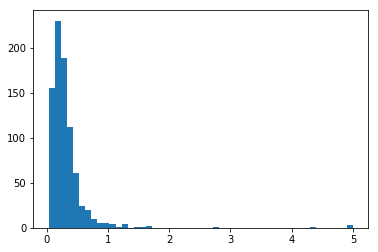

In [45]:
plt.hist(lst,bins=50);